In [1]:
import sklearn as sk
%matplotlib inline

import pandas as pd; pd.set_option('display.max_columns', None)
from sklearn.model_selection import train_test_split

Load

In [2]:
# Load df_data
df_data = pd.read_csv(r'C:\Users\rol3x\MAIN_PATH\df_data.csv',delimiter =',')

In [3]:
# Load in test_data, check if everuthing checks out, compare with df_data
test_data = pd.read_csv(r'C:\Users\rol3x\MAIN_PATH\testwlabel.csv',delimiter =',')


In [4]:
# Drop Unnamed: 0 from bots sets, it tries to identify client number. The sets already have nr as enrty.
df_data = df_data.drop(['Unnamed: 0'],axis=1)
test_data = test_data.drop(['Unnamed: 0'],axis=1)

In [5]:
# Promotion set to 0 & 1

df_data.Promotion = df_data.Promotion.map({'Not Received': 0, 'Received': 1})

In [6]:
# Assign features in a dataframe separately form 'Promotion' and 'y'

df =['age','job','marital','education','housing','contact','month','day_of_week','duration','previous','poutcome']

For convenience, we will declare some variables:

In [7]:
# split data into train and valid
train, valid = sk.model_selection.train_test_split(df_data, test_size=0.2,random_state=42)

In [8]:

X_train =train[df]
y_train = train['y']
treat_train = train['Promotion']

X_val = valid [df]
y_val = valid ['y']
treat_val =  valid ['Promotion']

X_train_full = train [df]
y_train_full = train ['y']
treat_train_full = train ['Promotion']

X_test = df

cat_features = ['job','marital','education']

models_results = {
    'approach': [],
    'uplift@30%': []
}

# 1. Single model approaches

# 1.1 Single model with treatment as feature

The most intuitive and simple uplift modeling technique. A training set consists of two groups: treatment samples and control samples. There is also a binary treatment flag added as a feature to the training set. After the model is trained, at the scoring time it is going to be applied twice: with the treatment flag equals 1 and with the treatment flag equals 0. Subtracting these model's outcomes for each test sample, we will get an estimate of the uplift.

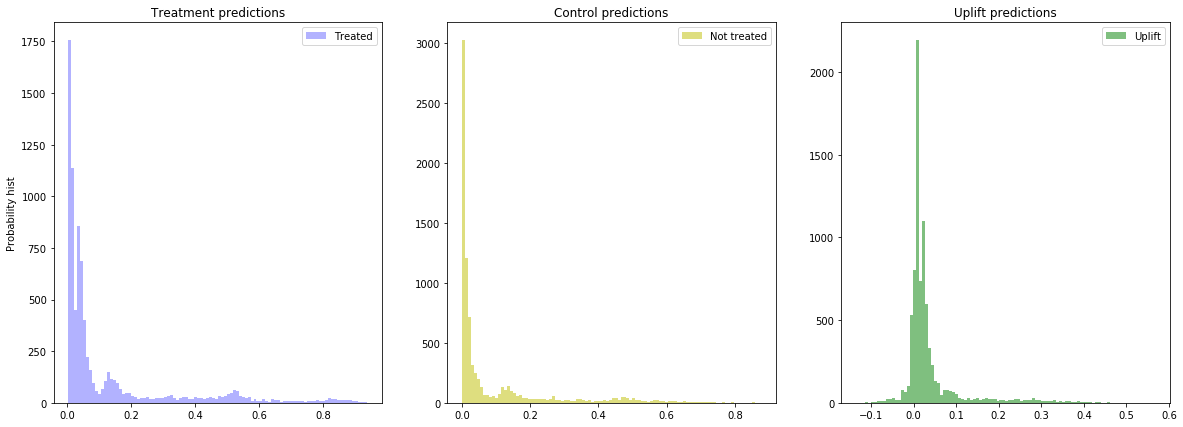

In [9]:
# installation instructions: https://github.com/maks-sh/scikit-uplift
# link to the documentation: https://scikit-uplift.readthedocs.io/en/latest/
from sklift.metrics import uplift_at_k
from sklift.viz import plot_uplift_preds
from sklift.models import SoloModel

# sklift supports all models, 
# that satisfy scikit-learn convention
# for example, let's use catboost
from catboost import CatBoostClassifier


sm = SoloModel(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
sm = sm.fit(X_train, y_train, treat_train, estimator_fit_params={'cat_features': cat_features})

uplift_sm = sm.predict(X_val)

sm_score = uplift_at_k(y_true=y_val, uplift=uplift_sm, treatment=treat_val, strategy='by_group', k=0.3)

models_results['approach'].append('SoloModel')
models_results['uplift@30%'].append(sm_score)

# get conditional probabilities (predictions) of performing the target action 
# during interaction for each object
sm_trmnt_preds = sm.trmnt_preds_
# And conditional probabilities (predictions) of performing the target action 
# without interaction for each object
sm_ctrl_preds = sm.ctrl_preds_

# draw the probability (predictions) distributions and their difference (uplift)
plot_uplift_preds(trmnt_preds=sm_trmnt_preds, ctrl_preds=sm_ctrl_preds);

- Use these graphs to compare to the cummulative gains chart, qini or aqini curve, other graphs from Part 1&2. They will validate eachother


In [10]:

# You can also access the trained model with the same ease.
# For example, to build the importance of features:
sm_fi = pd.DataFrame({
    'feature_name': sm.estimator.feature_names_,
    'feature_score': sm.estimator.feature_importances_
}).sort_values('feature_score', ascending=False).reset_index(drop=True)

sm_fi

,feature_name,feature_score
0,month,28.949891
1,duration,24.555309
2,contact,14.601117
3,poutcome,8.472597
4,treatment,7.341878
5,previous,4.840428
6,job,3.554136
7,age,2.735938
8,education,2.202454
9,day_of_week,1.874859


In [20]:
sklift.metrics.metrics.uplift_by_percentile(y_true, uplift, treatment, strategy='overall', bins=10, std=False, total=False)

NameError: name 'sklift' is not defined

# 2. Approaches with two models

The two-model approach can be found in almost any uplift modeling work and is often used as a baseline. However, using two models can lead to some unpleasant consequences: if you use fundamentally different models for training, or if the nature of the test and control group data is very different, then the scores returned by the models will not be comparable. As a result, the calculation of the uplift will not be completely correct. To avoid this effect, you need to calibrate the models so that their scores can be interpolated as probabilities.

2.1 Two independent models

The main idea is to estimate the conditional probabilities of the treatment and control groups separately.

- Train the first model using the treatment set.
- Train the second model using the control set.
- Inference: subtract the control model scores from the treatment model scores.

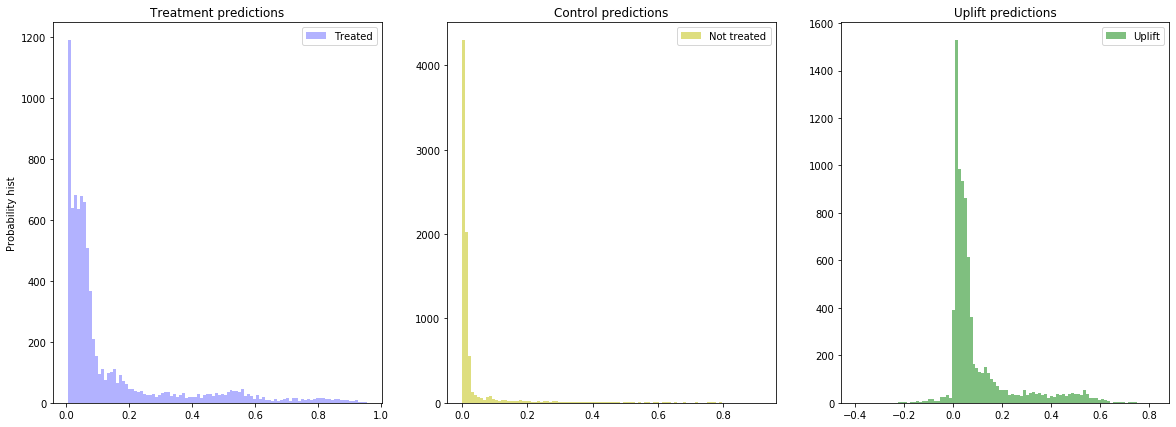

In [11]:

from sklift.models import TwoModels


tm = TwoModels(
    estimator_trmnt=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    estimator_ctrl=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    method='vanilla'
)
tm = tm.fit(
    X_train, y_train, treat_train,
    estimator_trmnt_fit_params={'cat_features': cat_features}, 
    estimator_ctrl_fit_params={'cat_features': cat_features}
)

uplift_tm = tm.predict(X_val)

tm_score = uplift_at_k(y_true=y_val, uplift=uplift_tm, treatment=treat_val, strategy='by_group', k=0.3)

models_results['approach'].append('TwoModels')
models_results['uplift@30%'].append(tm_score)

plot_uplift_preds(trmnt_preds=tm.trmnt_preds_, ctrl_preds=tm.ctrl_preds_);

2.2 Two dependent models

The dependent data representation approach is based on the classifier chain method originally developed for multi-class classification problems. The idea is that if there are $L$ different classifiers, each of which solves the problem of binary classification and in the learning process, each subsequent classifier uses the predictions of the previous ones as additional features. The authors of this method proposed to use the same idea to solve the problem of uplift modeling in two stages.

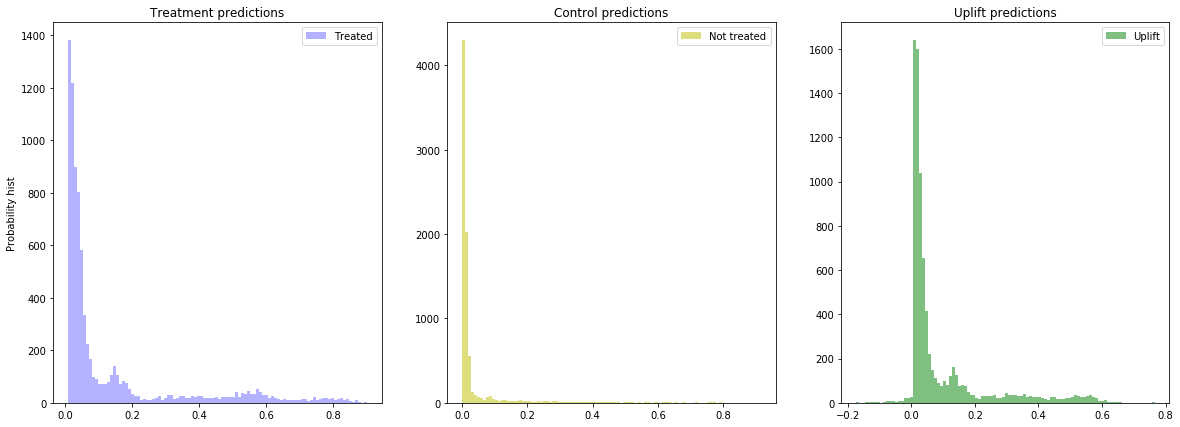

In [12]:
tm_ctrl = TwoModels(
    estimator_trmnt=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    estimator_ctrl=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    method='ddr_control'
)
tm_ctrl = tm_ctrl.fit(
    X_train, y_train, treat_train,
    estimator_trmnt_fit_params={'cat_features': cat_features}, 
    estimator_ctrl_fit_params={'cat_features': cat_features}
)

uplift_tm_ctrl = tm_ctrl.predict(X_val)

tm_ctrl_score = uplift_at_k(y_true=y_val, uplift=uplift_tm_ctrl, treatment=treat_val, strategy='by_group', k=0.3)

models_results['approach'].append('TwoModels_ddr_control')
models_results['uplift@30%'].append(tm_ctrl_score)

plot_uplift_preds(trmnt_preds=tm_ctrl.trmnt_preds_, ctrl_preds=tm_ctrl.ctrl_preds_);

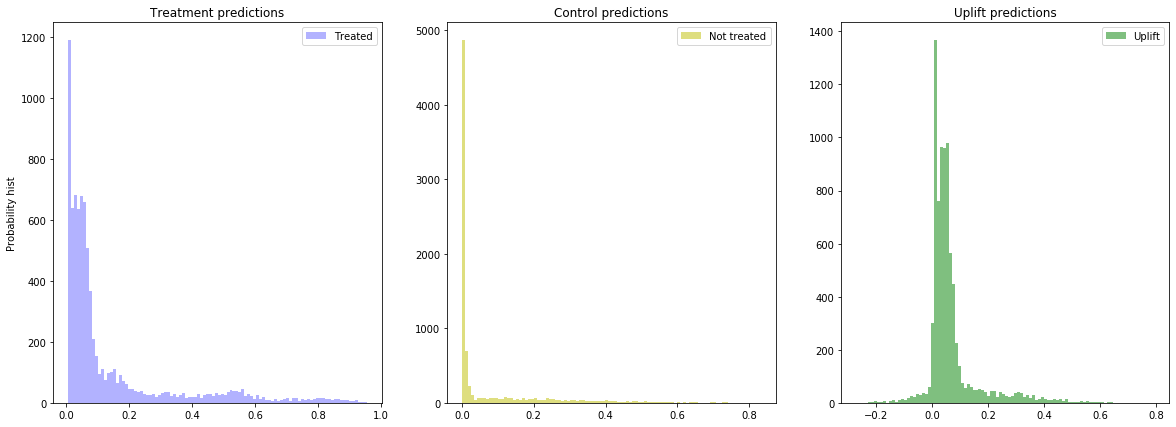

In [13]:
tm_trmnt = TwoModels(
    estimator_trmnt=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    estimator_ctrl=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    method='ddr_treatment'
)
tm_trmnt = tm_trmnt.fit(
    X_train, y_train, treat_train,
    estimator_trmnt_fit_params={'cat_features': cat_features}, 
    estimator_ctrl_fit_params={'cat_features': cat_features}
)

uplift_tm_trmnt = tm_trmnt.predict(X_val)

tm_trmnt_score = uplift_at_k(y_true=y_val, uplift=uplift_tm_trmnt, treatment=treat_val, strategy='by_group', k=0.3)

models_results['approach'].append('TwoModels_ddr_treatment')
models_results['uplift@30%'].append(tm_trmnt_score)

plot_uplift_preds(trmnt_preds=tm_trmnt.trmnt_preds_, ctrl_preds=tm_trmnt.ctrl_preds_);

In [14]:

pd.DataFrame(data=models_results).sort_values('uplift@30%', ascending=False)

,approach,uplift@30%
2,TwoModels_ddr_control,0.423090
1,TwoModels,0.414192
3,TwoModels_ddr_treatment,0.402060
0,SoloModel,0.338936


In [15]:
# import approaches
from sklift.models import SoloModel, ClassTransformation, TwoModels
# import any estimator adheres to scikit-learn conventions.
from catboost import CatBoostClassifier


# define models
treatment_model = CatBoostClassifier(iterations=50, thread_count=3,
                                     random_state=42, silent=True)
control_model = CatBoostClassifier(iterations=50, thread_count=3,
                                   random_state=42, silent=True)

# define approach
tm = TwoModels(treatment_model, control_model, method='vanilla')
# fit model
tm = tm.fit(X_train, y_train, treat_train)

# predict uplift
uplift_preds = tm.predict(X_val)

In [16]:
# import metrics to evaluate your model
from sklift.metrics import (
    uplift_at_k, uplift_auc_score, qini_auc_score, weighted_average_uplift
)


# Uplift@30%
tm_uplift_at_k = uplift_at_k(y_true=y_val, uplift=uplift_preds,
                             treatment=treat_val,
                             strategy='overall', k=0.3)

# Area Under Qini Curve
tm_qini_auc = qini_auc_score(y_true=y_val, uplift=uplift_preds,
                             treatment=treat_val)

# Area Under Uplift Curve
tm_uplift_auc = uplift_auc_score(y_true=y_val, uplift=uplift_preds,
                                 treatment=treat_val)

# Weighted average uplift
tm_wau = weighted_average_uplift(y_true=y_val, uplift=uplift_preds,
                                 treatment=treat_val)

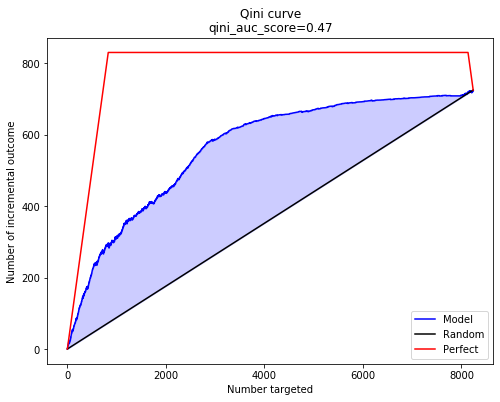

In [17]:
from sklift.viz import plot_qini_curve

plot_qini_curve(y_true=y_val, uplift=uplift_preds, treatment=treat_val)

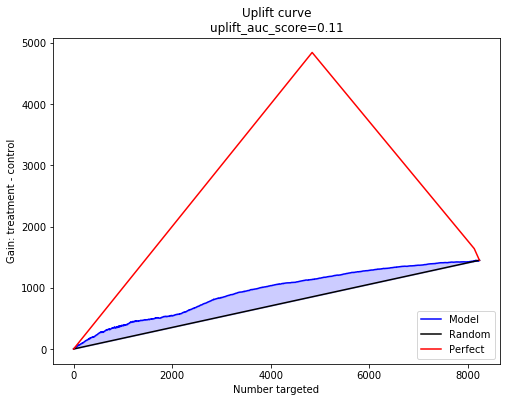

In [18]:
from sklift.viz import plot_uplift_curve

plot_uplift_curve(y_true=y_val, uplift=uplift_preds, treatment=treat_val)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001F18AD5F248>,
      dtype=object)

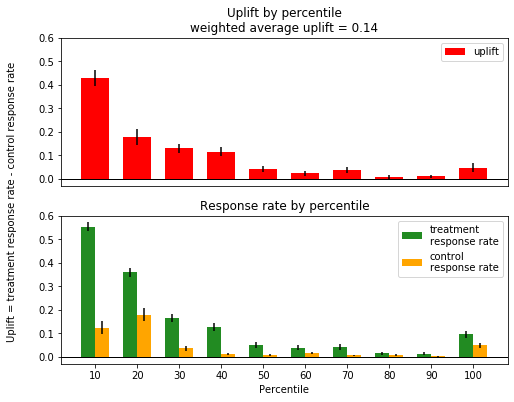

In [19]:
from sklift.viz import plot_uplift_by_percentile

plot_uplift_by_percentile(y_true=y_val, uplift=uplift_preds,
                          treatment=treat_val, kind='bar')